In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import sklearn.metrics
import keras
import pydicom
import random
from PIL import Image

Using TensorFlow backend.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
#Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
# Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load sample data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5543,00030220_000.png,Infiltration,0,30220,048Y,M,PA,1960,1862,0.194311,0.194311
3506,00017240_000.png,Effusion|Infiltration,0,17240,011Y,M,AP,2500,2048,0.168000,0.168000
3650,00017972_040.png,Pleural_Thickening,40,17972,015Y,M,AP,3056,2544,0.139000,0.139000


No Finding                           60361
Infiltration                          9547
Atelectasis                           4215
Effusion                              3955
Nodule                                2705
Pneumothorax                          2194
Mass                                  2139
Effusion|Infiltration                 1603
Atelectasis|Infiltration              1350
Consolidation                         1310
Atelectasis|Effusion                  1165
Pleural_Thickening                    1126
Cardiomegaly                          1093
Emphysema                              892
Infiltration|Nodule                    829
Atelectasis|Effusion|Infiltration      737
Fibrosis                               727
Edema                                  628
Cardiomegaly|Effusion                  484
Consolidation|Infiltration             441
Infiltration|Mass                      420
Effusion|Pneumothorax                  403
Effusion|Mass                          402
Atelectasis

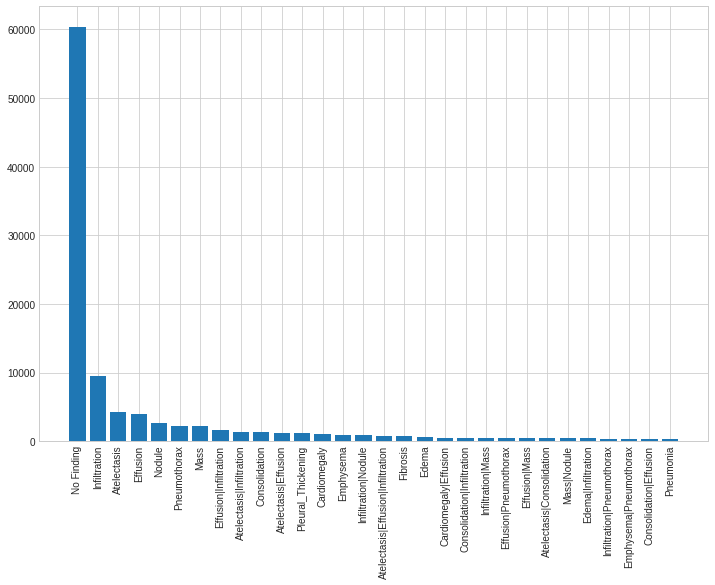

In [24]:
## EDA
# Todo 
# Distribution of the diseases in the datasets
labels = all_xray_df['Finding Labels'].value_counts()[:30]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(labels))+0.5, labels)
ax1.set_xticks(np.arange(len(labels))+0.5)
_ = ax1.set_xticklabels(labels.index, rotation = 90)


In [4]:
# Extraxt different diseases from the 'Finding labels' column
#Diseases = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
#print('Labels', Diseases)

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)



All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81431,00020011_000.png,Infiltration,0,20011,16,F,PA,2540,2924,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10064,00002611_001.png,No Finding,1,2611,52,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33274,00008727_011.png,No Finding,11,8727,55,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Number of Male in the dataset = 63340
Percentages of the Males:  56.49304316803425
Number of Females in the dataset = 48780
Percentages of the Females:  43.50695683196575


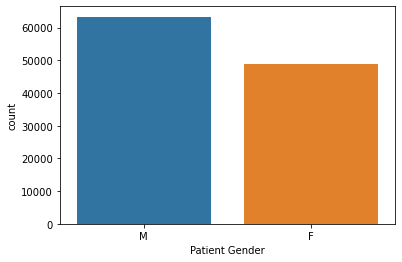

In [5]:
sns.countplot(x = 'Patient Gender', data =all_xray_df )
# Numbers of males and femals in the dataset
Males_Number = len(all_xray_df[all_xray_df['Patient Gender'] == "M"])
Females_Number = len(all_xray_df[all_xray_df['Patient Gender'] == "F"])
Total = len(all_xray_df)
print("Number of Male in the dataset =",Males_Number) 
print("Percentages of the Males: ", ((Males_Number)/ Total)*100 )

print("Number of Females in the dataset =",Females_Number) 
print("Percentages of the Females: ", ((Females_Number)/ Total)*100 )



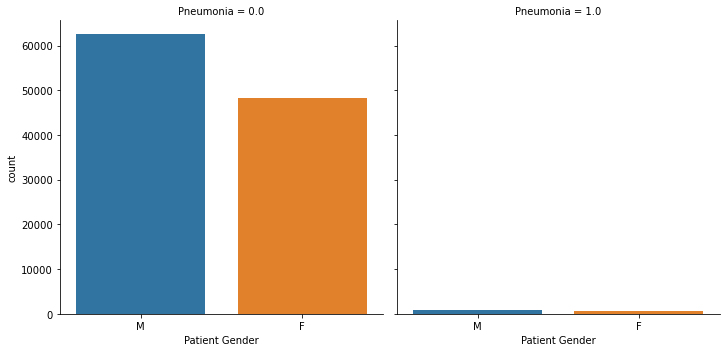

In [6]:
# Plotting the count of men and women you have positive cases of penumonia 
sns.catplot(x = 'Patient Gender', col = 'Pneumonia', kind = 'count', data=all_xray_df)

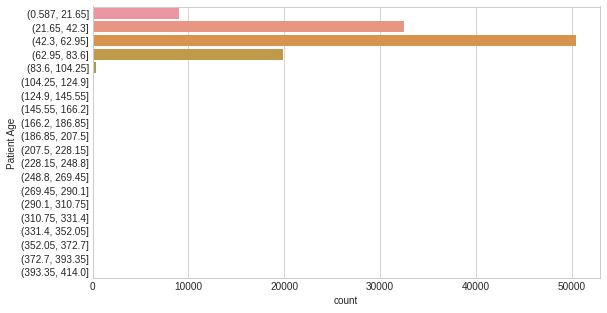

In [7]:
# Distribution of the ages of the people who have positive cases
binary_data = pd.DataFrame()
continous_data = pd.DataFrame()
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
binary_data['Patient Age'] = pd.cut(all_xray_df['Patient Age'] ,20)
sns.countplot(y = 'Patient Age', data = binary_data);

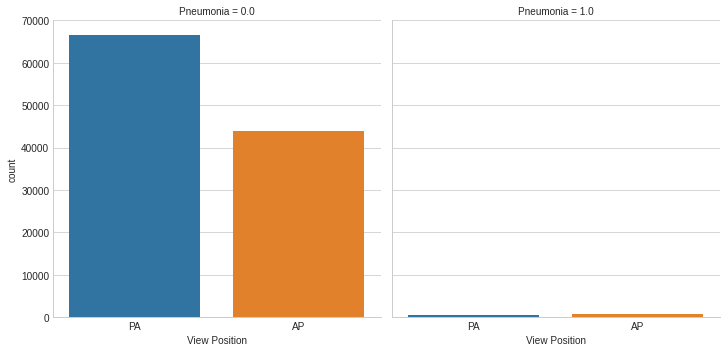

In [8]:
# Distribution of the position of the patiend
sns.catplot(x = 'View Position', col = 'Pneumonia', kind = 'count', data=all_xray_df)

In [9]:
# Distribution of the number of cases of penumonia cases versus non-Penumonia
#plt.style.use('seaborn-whitegrid')
#plt.figure(figsize=(20,30)) 
#sns.countplot(y="Finding Labels", data=all_xray_df);

In [10]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

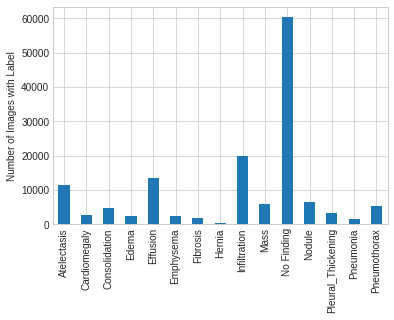

In [11]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

[Text(0.5, 1.0, 'Frequency Distribution label wise of each disease that co occur with penumonia')]

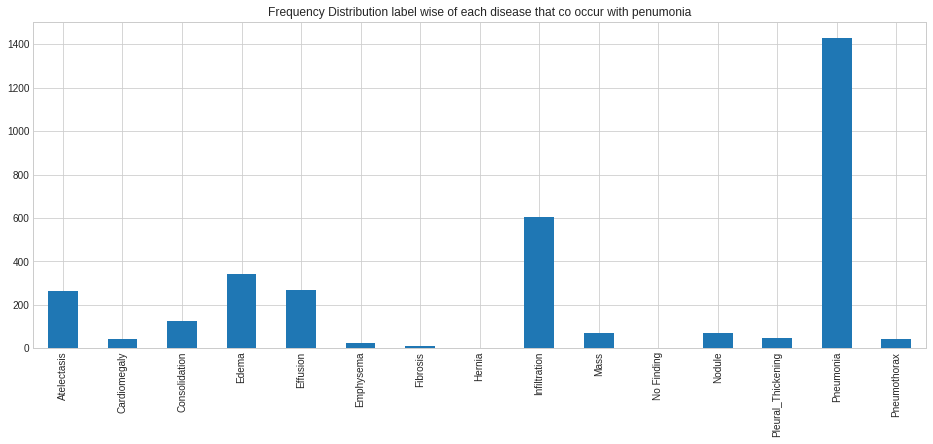

In [61]:
plt.figure(figsize=(16,6))
comorbidities =all_xray_df[all_xray_df.Pneumonia == 1][all_labels].sum(axis = 0, skipna = True)[:30].plot(kind='bar')
comorbidities.set(title = 'Frequency Distribution label wise of each disease that co occur with penumonia')

- The penumonia occurs alone for the most cases.
- The common comorbidities are the Infiltration and the Edema


(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

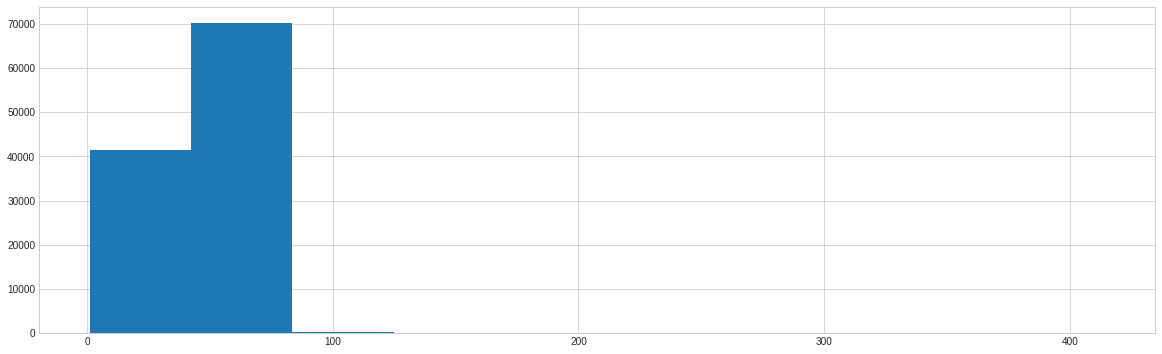

In [16]:
plt.figure(figsize=(20,6))
plt.hist(all_xray_df['Patient Age'])

- Another representation for the ages of the people inside the dataframe

(array([615., 811.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.,  43.,  84., 125., 166., 207., 248., 289., 330., 371., 412.]),
 <a list of 10 Patch objects>)

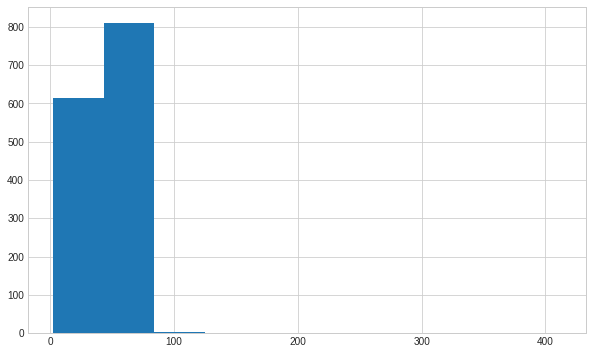

In [17]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])

- Distribution of the age of the patient who suffer from pneumonia

(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

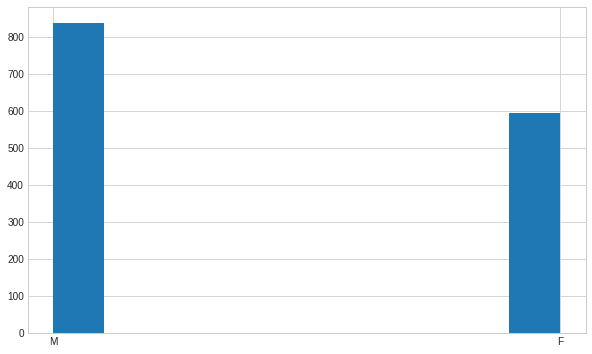

In [18]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'])

- Another Distibution for the Pneumonia patient versus the gender of the patient 

In [19]:
np.mean(all_xray_df['Pneumonia'] == 0.0)

0.9872368890474491

In [20]:
np.mean(all_xray_df['Pneumonia'] == 1.0)

0.012763110952550838

In [21]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


[B]: Visualize relevant properties of pixel-level data
1. Visualize medical images during EDA

Patient ID: 2
Modality: DX
Patient Gender: M
Patient Age: 81


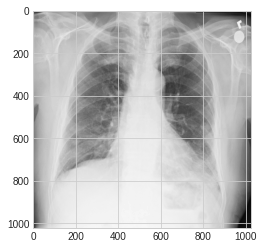

In [22]:
dcm_1 = pydicom.dcmread('test1.dcm')
image = dcm_1.pixel_array
plt.imshow(image, cmap = 'gray')
print('Patient ID:',dcm_1.PatientID)
print('Modality:',dcm_1.Modality)
print('Patient Gender:',dcm_1.PatientSex)
print('Patient Age:',dcm_1.PatientAge)

Patient ID: 2
Modality: DX
Patient Gender: M
Patient Age: 81


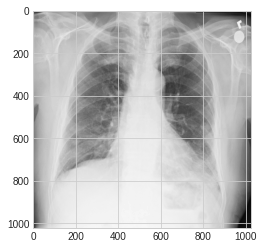

In [23]:
dcm_6 = pydicom.dcmread('test6.dcm')
image = dcm_6.pixel_array
plt.imshow(image, cmap = 'gray')
print('Patient ID:',dcm_6.PatientID)
print('Modality:',dcm_6.Modality)
print('Patient Gender:',dcm_6.PatientSex)
print('Patient Age:',dcm_6.PatientAge)

2. Distribution Intensity of pixel level data 

Study Description: No Finding


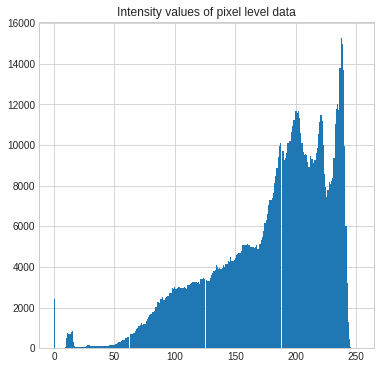

In [24]:
plt.figure(figsize=(6,6))
plt.hist(dcm_1.pixel_array.ravel(), bins = 256)
plt.title('Intensity values of pixel level data')
print('Study Description:',dcm_1.StudyDescription)

Study Description: No Finding


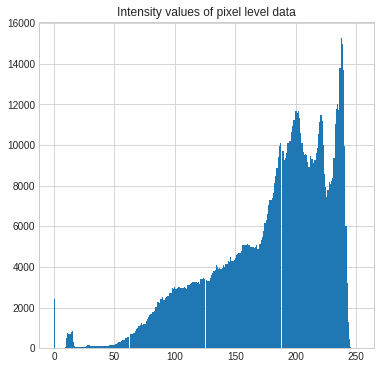

In [25]:
plt.figure(figsize=(6,6))
plt.hist(dcm_6.pixel_array.ravel(), bins = 256)
plt.title('Intensity values of pixel level data')
print('Study Description:',dcm_6.StudyDescription)

3. Normalize Image to bring its intensity closer to zero

mean Intensity:  180.0586576461792



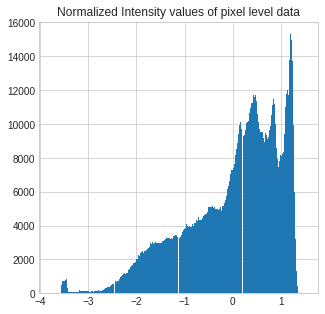

In [26]:
# Normalizing image dcm_6
mean_intensity = np.mean(dcm_6.pixel_array)
std_intensity = np.std(dcm_6.pixel_array)
new_img = dcm_6.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized Intensity values of pixel level data')
print('mean Intensity: ', mean_intensity)
print('')

4. Use the coordinates in the dataframe

In [29]:
df = pd.read_csv('sample_labels.csv')

In [30]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


Pneumonia cases:  14


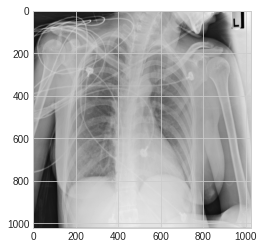

In [77]:
all_pneumonia_cases = df[df['Finding Labels']== 'Pneumonia']
random_cases = all_pneumonia_cases.iloc[0]["Image Index"] # Choose random image
Random_image_loc = '/data/'
pneumonia_count = len(all_pneumonia_cases)
print('Pneumonia cases: ',pneumonia_count)

locations = {}
for dirs, subdirs, files in os.walk('/data/', topdown= True):
    for file in files:
        locations[file] = os.path.join(dirs, file)
image = Image.open(locations[random_cases])    
plt.imshow(image,cmap= 'gray')

- Compare Intensity profiles of different sections of an image [Center pixels]

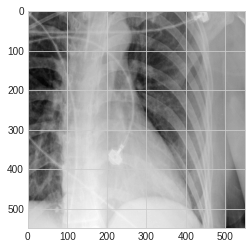

In [78]:
area = (300, 300, 850, 850)
cropped_img = image.crop(area)
plt.imshow(cropped_img, cmap='gray')

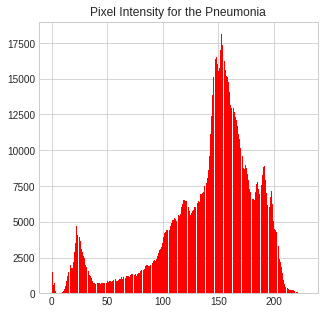

In [79]:
plt.figure(figsize=(5,5))
plt.hist(np.array(image.getdata()).ravel(), bins = 256,color='red')
plt.title('Pixel Intensity for the Pneumonia')
plt.show()

- Getting the pixel intensity of the all diseases to compare them with 'Pneumonia' pixel intensity

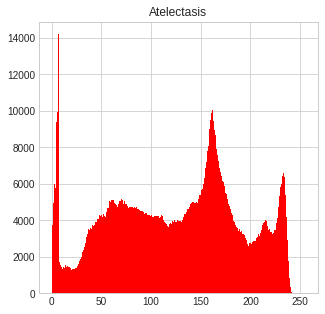

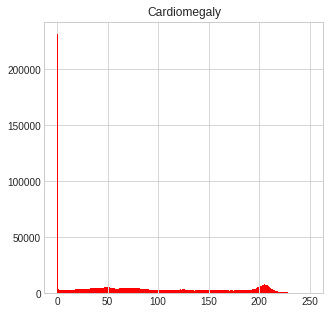

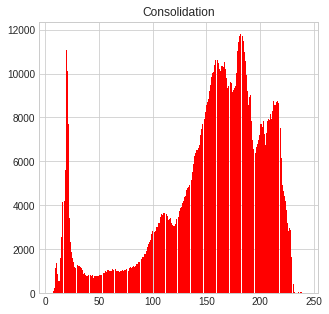

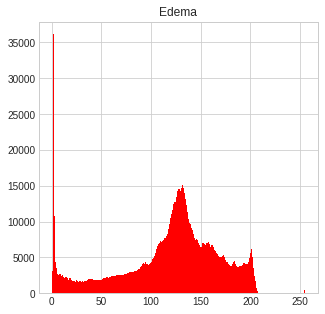

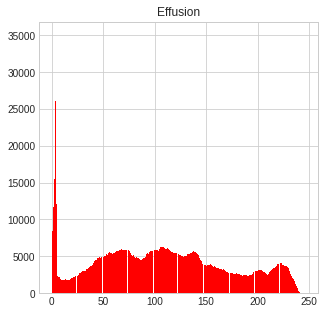

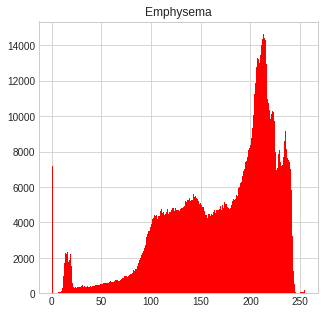

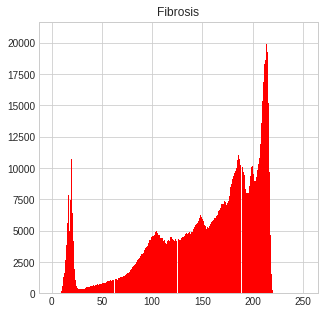

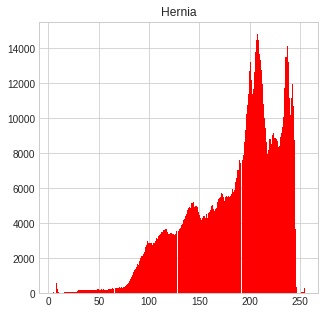

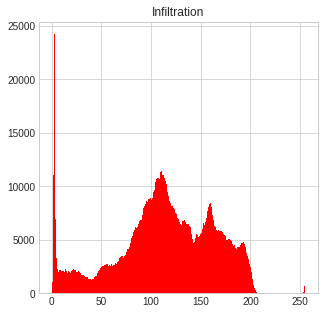

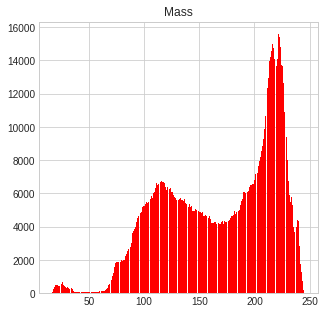

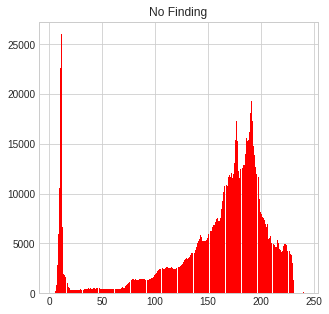

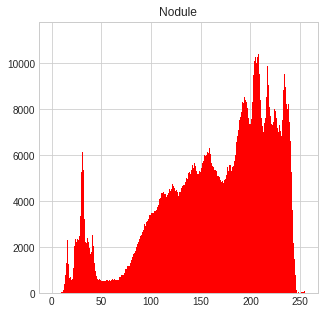

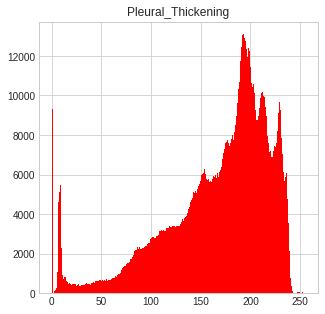

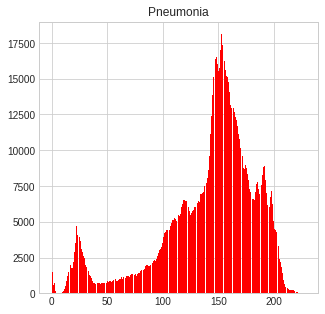

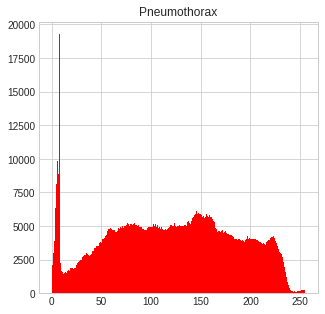

In [83]:
plot_only_one = False
locations = {}
for disease in all_labels:
    Disease_cases = df[df['Finding Labels']== disease] 
    random_disease_case = Disease_cases.iloc[0]['Image Index'] # Choosing a random cases of each diseases
    for dirs, subdirs, files in os.walk('/data/', topdown= True):
        for file in files:
            locations[file] = os.path.join(dirs, file)
    
    Disease_image = Image.open(locations[random_disease_case])
    # Plotting the Pixel Intensity of the disease
    plt.figure(figsize=(5,5))
    plt.hist(np.array(Disease_image.getdata()).ravel(), bins = 256,color='red')
    plt.title(disease)

- In my conculsion about which disease has similar pixel distribution as 'Pneumonia'.
- At the beginning, I have checked the pixel intensity of the 'Pneumonia' disease for more than one image.
- I have found that the distributions collobrate in the following features.
- The pneumonia distributions have two peaks in the x-axis at around '150' & '200'.
- Also the y-axis is around '18000'.
- Taking this in consideration the following diseases have similar pixel distributions, (Consolidation, Mass, Cardimegaly).
- Also the distribution of the (No Finding) label is similar to the one of the (Pneumonia).
- This shows how much the indentification process is not a such easy job.
- Regarding the similar diseases choice, I have compared more than iteration of random choice of the images in order to conclude and choose the above diseases. 